In [1]:
import json
import os
import shutil
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from nltk.corpus import stopwords
import time
import datetime
import pickle
import joblib
import string
import shap
from langdetect import detect
from deep_translator import GoogleTranslator
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from tqdm import tqdm
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

In [ ]:
#Opening & reading json file
with open("kaggle.json", "r") as f:
    kaggle_creds=json.load(f)

#Display the content
print(kaggle_creds)

{'username': 'nikgupt007', 'key': '3bfbb9316dd72f76a4b31abeaa6f6b9c'}


In [ ]:
#Defining the path for kaggle API key
kaggle_dir=os.path.join(os.path.expanduser("~"), ".kaggle")

#Creating kaggle directory
os.makedirs(kaggle_dir, exist_ok=True)

#Moving the file to the correct location
shutil.move("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))

#Verifying the file correct location
print(os.listdir(kaggle_dir))

['kaggle.json']


**<font size="5">Importing Twitter Sentiment dataset</font>**

In [ ]:
#API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other




  0%|          | 0.00/80.9M [00:00<?, ?B/s]
  1%|1         | 1.00M/80.9M [00:01<01:44, 800kB/s]
  2%|2         | 2.00M/80.9M [00:01<01:06, 1.24MB/s]
  4%|3         | 3.00M/80.9M [00:02<00:50, 1.62MB/s]
  5%|4         | 4.00M/80.9M [00:02<00:43, 1.86MB/s]
  6%|6         | 5.00M/80.9M [00:03<00:38, 2.07MB/s]
  7%|7         | 6.00M/80.9M [00:03<00:32, 2.43MB/s]
  9%|8         | 7.00M/80.9M [00:03<00:31, 2.48MB/s]
 10%|9         | 8.00M/80.9M [00:04<00:30, 2.52MB/s]
 11%|#1        | 9.00M/80.9M [00:04<00:36, 2.06MB/s]
 12%|#2        | 10.0M/80.9M [00:05<00:34, 2.19MB/s]
 14%|#3        | 11.0M/80.9M [00:05<00:30, 2.41MB/s]
 15%|#4        | 12.0M/80.9M [00:05<00:26, 2.78MB/s]
 16%|#6        | 13.0M/80.9M [00:06<00:30, 2.33MB/s]
 17%|#7        | 14.0M/80.9M [00:06<00:24, 2.90MB/s]
 19%|#8        | 15.0M/80.9M [00:06<00:21, 3.15MB/s]
 20%|#9        | 16.0M/80.9M [00:07<00:23, 2.84MB/s]
 21%|##1       | 17.0M/80.9M [00:07<00:26, 2.50MB/s]
 22%|##2       | 18.0M/80.9M [00:08<00:23, 2.80MB/s]
 2

In [ ]:
#Extracting the compressed dataset
dataset='sentiment140.zip'

#Opening the file
with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print("The dataset is extracted")

The dataset is extracted


**<font size="10">Data Processing</font>**

In [ ]:
#Naming the columns
column_names=['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data=pd.read_csv("/content/training.1600000.processed.noemoticon.xls", names=column_names, encoding='ISO-8859-1')

#Setting display option to get all rows
pd.set_option('display.max_rows', 100)

#Displaying first 100 rows
twitter_data.head(100)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


The dataset is missing headers. So I have included headers manually from dataset website.

In [ ]:
#Displaying 100 middle rows
mid_rows = twitter_data.iloc[800000:800100]
mid_rows

,target,id,date,flag,user,text
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
800005,4,1467822391,Mon Apr 06 22:22:47 PDT 2009,NO_QUERY,ajarofalmonds,@ProductOfFear You can tell him that I just bu...
800006,4,1467822447,Mon Apr 06 22:22:51 PDT 2009,NO_QUERY,vmdavinci,@r_keith_hill Thans for your response. Ihad al...
800007,4,1467822465,Mon Apr 06 22:22:48 PDT 2009,NO_QUERY,jessicavaliyi,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,1467822489,Mon Apr 06 22:22:49 PDT 2009,NO_QUERY,emmasaur28,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,1467822496,Mon Apr 06 22:22:49 PDT 2009,NO_QUERY,SherylBreuker,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [ ]:
#Displaying last 100 rows
twitter_data.tail(100)

,target,id,date,flag,user,text
1599900,4,2193574897,Tue Jun 16 08:38:37 PDT 2009,NO_QUERY,johnwelshphd,@cris1015 My goal on stocks like $MTXX is to h...
1599901,4,2193574981,Tue Jun 16 08:38:38 PDT 2009,NO_QUERY,RockComplacency,@wolfpack40 That's what I'm thinking! Knock he...
1599902,4,2193574986,Tue Jun 16 08:38:38 PDT 2009,NO_QUERY,xxiolla1,@Jchawes yeah what about remotes for your car ...
1599903,4,2193575000,Tue Jun 16 08:38:38 PDT 2009,NO_QUERY,Ten_Tenths,Post your Le Mans 2009 pics: .. I didn't reall...
1599904,4,2193575004,Tue Jun 16 08:38:38 PDT 2009,NO_QUERY,say_my_name_too,@say_my_name TRAITOR!!!! love you
1599905,4,2193575079,Tue Jun 16 08:38:38 PDT 2009,NO_QUERY,CaraIsaac,@SarahG8s lol i wasnt on about the burns lol i...
1599906,4,2193575126,Tue Jun 16 08:38:39 PDT 2009,NO_QUERY,Gregor_Boyd,been playing big surf island and i've unlocked...
1599907,4,2193575210,Tue Jun 16 08:38:39 PDT 2009,NO_QUERY,themunny,@gabespears morning
1599908,4,2193575214,Tue Jun 16 08:38:39 PDT 2009,NO_QUERY,xDevikax,I really dont get why Jaylor split . Oh well h...
1599909,4,2193575236,Tue Jun 16 08:38:39 PDT 2009,NO_QUERY,drjan,my cluster is back and I'm a happy man


In the twitter data the tweets contain username, special characters, punctuations, numerical values, abbreviation and different language tweets. Also some tweets are of only one word. It doesn't contain any garbage.

In [ ]:
#Checking shape
twitter_data.shape

(1600000, 6)

**<font size="5">The dataset contains 1.6 million rows and 6 columns</font>**

**<font size="10">Exploratory Data Analysis</font>**

In [ ]:
#Checking info
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
#Checking for null values
pd.DataFrame({'Count': twitter_data.isnull().sum(), 'Percentage': twitter_data.isnull().sum()/len(twitter_data)})

,Count,Percentage
target,0,0.0
id,0,0.0
date,0,0.0
flag,0,0.0
user,0,0.0
text,0,0.0


<font size="">The null counts of dataset is 0</font>

In [ ]:
#Checking for Null, Nan, None, Na or N/A in rows
mask = twitter_data[column_names].apply(lambda col: col.astype(str).str.contains(r'^\s*(?:null|nan|na|none|n/a)\s*$', case=False, na=False))

#Filter rows where any columns contains these values
filtered_data = twitter_data[mask.any(axis=1)]
print(filtered_data)

Empty DataFrame
Columns: [target, id, date, flag, user, text]
Index: []


Our dataset doesn't contain any mislabeled missing values like Null, Nan, None, Na or N/A

In [ ]:
#Checking for duplicates
pd.DataFrame([{'Count': twitter_data.duplicated().sum(), 'Percentage': twitter_data.duplicated().sum()/len(twitter_data)}])

,Count,Percentage
0,0,0.0


<font size="">The dataset has no duplicate values</font>

In [ ]:
#Checking distribution of the target variable
twitter_data['target'].value_counts()/len(twitter_data)

,count
target,
0,0.5
4,0.5


In [ ]:
#Mapping target 4 to 1
twitter_data.replace({'target':{4:1}}, inplace=True)

In [ ]:
#Checking distribution of the target variable again
Target_ratio=twitter_data['target'].value_counts()/len(twitter_data)
print(Target_ratio)

target
0    0.5
1    0.5
Name: count, dtype: float64


<font size="5"> Here 0 represent Negative Tweet which is 50%.</font>

<font size="5">And 1 represent Positive Tweet which is 50%.</font>

<font size="5">Hence our target variable is balanced.</font>

In [ ]:
#Analyzing text length
twitter_data['text'].apply(len).describe()

,text
count,1.600000e+06
mean,7.409011e+01
std,3.644114e+01
min,6.000000e+00
25%,4.400000e+01
50%,6.900000e+01
75%,1.040000e+02
max,3.740000e+02


In [ ]:
#Lower & Higher Percentiles for text
percentiles = [0.01, 0.025, 0.05, 0.10, 0.30, 0.90, 0.95, 0.99, 1.0]
quantiles = twitter_data['text'].apply(len).quantile(percentiles)

quantiles.index = [f"{int(p*100)}%" for p in percentiles]
print(quantiles)

1%       14.0
2%       18.0
5%       22.0
10%      28.0
30%      49.0
90%     130.0
95%     136.0
99%     141.0
100%    374.0
Name: text, dtype: float64


In [ ]:
#Analyzing word count
twitter_data['text'].str.split().apply(len).describe()

,text
count,1.600000e+06
mean,1.317615e+01
std,6.957978e+00
min,1.000000e+00
25%,7.000000e+00
50%,1.200000e+01
75%,1.900000e+01
max,6.400000e+01


In [ ]:
#Lower & Higher percentile for word
w_percentiles = [0.01, 0.025, 0.05, 0.10, 0.30, 0.90, 0.95, 0.99, 1.0]
w_quantiles = twitter_data['text'].str.split().apply(len).quantile(w_percentiles)

w_quantiles.index = [f"{int(p*100)}%" for p in w_percentiles]
print(w_quantiles)

1%       2.0
2%       3.0
5%       3.0
10%      5.0
30%      8.0
90%     23.0
95%     25.0
99%     28.0
100%    64.0
Name: text, dtype: float64


On observing the text & word count you will find there is not much difference between 1%, 2%, 5% & 10%. It means the length of tweets are nearly same. But if you observe 10% & 30% there is some difference indicating some tweets are large. And if you observe 30%, 90% & 99% there is much difference indicating some tweets are very large. If you observe 99% & 100% there too much difference indicating some tweets are extremely large. If you observe 1% you will find some tweets contain single word but if you observe 100% you will find some tweets are extremely large.

**<font size="5">Text Cleaning or Normalization</font>**

In [ ]:
#Removing username, link, special characters, punctuations, numbers & extra spaces
def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text

#Applying function to text column
twitter_data['text'] = twitter_data['text'].apply(clean_text)

#Returning dataframe
twitter_data

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is the best feel...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom very cool to hear old walt interviews
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy th birthday to my boo of alll time tupac...


In [ ]:
#Function to translate text
def translate_to_english(text):
    try:
        lang = detect(text)
        if lang != 'en':
            return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return text
    return text

#Tracking progress
tqdm.pandas()

# Apply translation to the "text" column
twitter_data["text"] = twitter_data["text"].progress_apply(translate_to_english)

#Final saving
twitter_data.to_csv("translated_tweets_final.csv", index=False)

#Displaying the dataframe
twitter_data

100%|██████████| 1600000/1600000 [7:40:17<00:00, 57.93it/s]


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is the best feel...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom very cool to hear old walt interviews
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy th birthday to my boo of alll time tupac...


In [ ]:
#Loading the datatset
twitter_data_v1=pd.read_csv("/content/translated_tweets_final.csv")
twitter_data_v1.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...


In [ ]:
#Evalutaing spacy, NLTK & TextBlob library
abbreviation_dict = {
    "Dr.": "Doctor",
    "Mr.": "Mister",
    "Mrs.": "Mistress",
    "Ms.": "Miss",
    "Jr.": "Junior",
    "Sr.": "Senior",
    "i.e.": "that is",
    "e.g.": "for example",
    "etc.": "et cetera",
    "vs.": "versus",
    "approx.": "approximately",
    "dept.": "department",
    "est.": "established",
    "no.": "number",
    "min.": "minute",
    "max.": "maximum",
    "avg.": "average",
    "vol.": "volume",
    "inc.": "incorporated",
    "ltd.": "limited",
    "Co.": "Company",
    "Corp.": "Corporation",
    "Pvt.": "Private",
    "Prof.": "Professor",
    "Rev.": "Reverend",
    "Jan.": "January",
    "Feb.": "February",
    "Aug.": "August",
    "Sept.": "September",
    "Oct.": "October",
    "Nov.": "November",
    "Dec.": "December"
}

test_sentences = [
    ("Dr. Smith is a neurologist.", "Doctor Smith is a neurologist."),
    ("Mr. Brown is waiting in the lobby.", "Mister Brown is waiting in the lobby."),
    ("Mrs. Green is our neighbor.", "Mistress Green is our neighbor."),
    ("Ms. Patel will join us shortly.", "Miss Patel will join us shortly."),
    ("James Jr. is only five.", "James Junior is only five."),
    ("Robert Sr. is the founder.", "Robert Senior is the founder."),
    ("We need to clarify this, i.e., be more specific.", "We need to clarify this, that is, be more specific."),
    ("We sell tools, e.g., hammers and drills.", "We sell tools, for example, hammers and drills."),
    ("Fruits like apples, bananas, etc. are healthy.", "Fruits like apples, bananas, et cetera are healthy."),
    ("The debate was between Tom vs. Jerry.", "The debate was between Tom versus Jerry."),
    ("The price is approx. $100.", "The price is approximately $100."),
    ("Contact the HR dept. for details.", "Contact the HR department for details."),
    ("The company was est. in 1995.", "The company was established in 1995."),
    ("This is case no. 45.", "This is case number 45."),
    ("Wait for 5 min. please.", "Wait for 5 minute please."),
    ("The max. score is 100.", "The maximum score is 100."),
    ("The avg. grade was B+.", "The average grade was B+."),
    ("The vol. of the book is large.", "The volume of the book is large."),
    ("Tesla Inc. is growing fast.", "Tesla incorporated is growing fast."),
    ("Tata Motors Ltd. is reliable.", "Tata Motors limited is reliable."),
    ("Apple Co. released a new product.", "Apple Company released a new product."),
    ("Meta Corp. has changed its name.", "Meta Corporation has changed its name."),
    ("X Pvt. Ltd. launched the app.", "X Private limited launched the app."),
    ("Prof. Alan is giving a lecture.", "Professor Alan is giving a lecture."),
    ("The Rev. will lead the prayer.", "The Reverend will lead the prayer."),
    ("The event is in Jan.", "The event is in January."),
    ("He was born in Feb.", "He was born in February."),
    ("School starts in Aug.", "School starts in August."),
    ("The exam is in Sept.", "The exam is in September."),
    ("Halloween is in Oct.", "Halloween is in October."),
    ("Thanksgiving is in Nov.", "Thanksgiving is in November."),
    ("Christmas is in Dec.", "Christmas is in December.")
]

In [ ]:
#Tokenization

#Download tokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
#NLTK Library
def expand_with_nltk(text, abbr_dict):
    tokens = word_tokenize(text)
    expanded = [abbr_dict.get(token, token) for token in tokens]
    return " ".join(expanded)

In [ ]:
#SpaCy Library
nlp = spacy.load("en_core_web_sm")

def expand_with_spacy(text, abbr_dict):
    doc = nlp(text)
    expanded = [abbr_dict.get(token.text, token.text) for token in doc]
    return " ".join(expanded)

In [ ]:
#TextBlob Library
def expand_with_textblob(text, abbr_dict):
    blob = TextBlob(text)
    expanded = [abbr_dict.get(word, word) for word in blob.words]
    return " ".join(expanded)

In [ ]:
#Normalizing
def normalize(text):
    text = text.lower()
    text = re.sub(r"\s+([.,;!?])", r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
#Evalutaion Function
def evaluate(lib_name, lib_func, test_data, abbr_dict):
    start_time = time.time()
    correct = 0
    total = len(test_data)

    for sent, expected in test_data:
        result = lib_func(sent, abbr_dict)
        if normalize(result) == normalize(expected):
            correct += 1

    end_time = time.time()
    duration = end_time - start_time
    accuracy = correct / total

    return {"library": lib_name, "accuracy": accuracy, "time": duration}

#Printing results
results = []
results.append(evaluate("NLTK", expand_with_nltk, test_sentences, abbreviation_dict))
results.append(evaluate("spaCy", expand_with_spacy, test_sentences, abbreviation_dict))
results.append(evaluate("TextBlob", expand_with_textblob, test_sentences, abbreviation_dict))

df = pd.DataFrame(results)
print("\n Comparison Table:\n")
print(df.sort_values("accuracy", ascending=False))


 Comparison Table:

    library  accuracy      time
0      NLTK     0.375  0.031290
1     spaCy     0.375  0.312216
2  TextBlob     0.000  0.005308


On evaluating NLTK, spaCy & TextBlob I found that NLTK & spaCy have same accuracy of 37.5% but TextBlob is having very low accuracy of 0.0%.
Also NLTK & spaCy have same accuracy but time elapsed by NLTK is lesser than spaCy. So NLTK is best for abbreviation expansion.

In [ ]:
#Tokenization

#Download tokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#Function to expand abbreviations using NLTK
def expand_wth_nltk(text, abbr_dict):
  if not isinstance(text, str):
    text = str(text)

  #Tokenize the text
  tokens = word_tokenize(text)

  expanded = []
  for word in tokens:
    clean_word = word.rstrip('.,;!?')
    expanded_word = abbr_dict.get(clean_word, word)
    expanded.append(expanded_word)

  return " ".join(expanded)

#Applying expansion to each tweet
twitter_data_v1['expanded_text'] = twitter_data_v1['text'].apply(lambda x: expand_wth_nltk(x, abbreviation_dict))

#Results
twitter_data_v1

,target,id,date,flag,user,text,expanded_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...
...,...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is the best feel...,just woke up having no school is the best feel...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom very cool to hear old walt interviews,thewdbcom very cool to hear old walt interviews
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...,are you ready for your mojo makeover ask me fo...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy th birthday to my boo of alll time tupac...,happy th birthday to my boo of alll time tupac...


In [ ]:
#Saving the preprocessed file
twitter_data_v1.to_csv('twitter_data_preprocessed_v2.csv', index=False)

In [ ]:
#Loading the datast
twitter_data_v2=pd.read_csv('twitter_data_preprocessed_v2.csv')
twitter_data_v2.head()

,target,id,date,flag,user,text,expanded_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...


In [ ]:
#Loading nlp model
nlp = spacy.load("en_core_web_sm")

#POS tagging
def extract_pos_tags(expanded_text):
  if not isinstance(expanded_text, str):
    return []
  doc=nlp(expanded_text)
  return [(token.text, token.pos_, token.tag_) for token in doc]

#Tracking progress
tqdm.pandas(desc="POS Tagging")

#Applying POS on each tweet
twitter_data_v2['pos_tags'] = twitter_data_v2['expanded_text'].progress_apply(extract_pos_tags)

POS Tagging: 100%|██████████| 1600000/1600000 [3:31:17<00:00, 126.21it/s]


In [ ]:
#Printing the dataset
twitter_data_v2

,target,id,date,flag,user,text,expanded_text,pos_tags
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[(awww, PROPN, NNP), (that, PRON, DT), (s, VER..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[(is, AUX, VBZ), (upset, ADJ, JJ), (that, SCON..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[(i, PRON, PRP), (dived, VERB, VBD), (many, AD..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[(my, PRON, PRP$), (whole, ADJ, JJ), (body, NO..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[(no, INTJ, UH), (its, PRON, PRP$), (not, PART..."
...,...,...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is the best feel...,just woke up having no school is the best feel...,"[(just, ADV, RB), (woke, VERB, VBD), (up, ADP,..."
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom very cool to hear old walt interviews,thewdbcom very cool to hear old walt interviews,"[(thewdbcom, VERB, VBP), (very, ADV, RB), (coo..."
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...,are you ready for your mojo makeover ask me fo...,"[(are, AUX, VBP), (you, PRON, PRP), (ready, AD..."
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy th birthday to my boo of alll time tupac...,happy th birthday to my boo of alll time tupac...,"[(happy, ADJ, JJ), (th, X, XX), (birthday, NOU..."


In [ ]:
#Saving the preprocessed file
twitter_data_v2.to_csv('twitter_data_preprocessed_v3.csv', index=False)

In [2]:
#Loading the dataset
twitter_data_v3 = pd.read_csv('twitter_data_preprocessed_v3.csv')
twitter_data_v3.head()

,target,id,date,flag,user,text,expanded_text,pos_tags
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')..."


In [3]:
# Load model
nlp = spacy.load("en_core_web_sm")

# Sample function to extract POS counts
def extract_pos_counts(text):
    doc = nlp(text)
    return {doc.vocab[k].text: v for k, v in doc.count_by(spacy.attrs.POS).items()}

# Add progress bar to pandas
tqdm.pandas(desc="Counting POS")

# Apply to DataFrame column
twitter_data_v3['pos_count'] = twitter_data_v3['pos_tags'].progress_apply(extract_pos_counts)

Counting POS: 100%|███████████████████████████████████████████████████████| 1600000/1600000 [18:29:46<00:00, 24.03it/s]


In [4]:
#Priniting the dataset
twitter_data_v3.head()

,target,id,date,flag,user,text,expanded_text,pos_tags,pos_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D...","{'X': 2, 'PUNCT': 180, 'PROPN': 20, 'PRON': 4,..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),...","{'X': 2, 'PUNCT': 236, 'AUX': 3, 'PROPN': 23, ..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'...","{'X': 1, 'PUNCT': 172, 'PRON': 3, 'VERB': 12, ..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'...","{'X': 2, 'PUNCT': 108, 'INTJ': 2, 'NOUN': 6, '..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')...","{'X': 1, 'PUNCT': 228, 'VERB': 16, 'INTJ': 3, ..."


In [5]:
#Saving the preprocessed file
twitter_data_v3.to_csv('twitter_data_preprocessed_v4.csv', index=False)

In [2]:
#Loading the dataset
twitter_data_v4 = pd.read_csv('twitter_data_preprocessed_v4.csv')
twitter_data_v4.head()

,target,id,date,flag,user,text,expanded_text,pos_tags,pos_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D...","{'X': 2, 'PUNCT': 180, 'PROPN': 20, 'PRON': 4,..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),...","{'X': 2, 'PUNCT': 236, 'AUX': 3, 'PROPN': 23, ..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'...","{'X': 1, 'PUNCT': 172, 'PRON': 3, 'VERB': 12, ..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'...","{'X': 2, 'PUNCT': 108, 'INTJ': 2, 'NOUN': 6, '..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')...","{'X': 1, 'PUNCT': 228, 'VERB': 16, 'INTJ': 3, ..."


In [3]:
#Downloadin tokenizer
nltk.download('punkt')

#Initialize Stemmer
stemmer = PorterStemmer()

#Defining stem
def stem_text(text):
    if not isinstance(text, str):
        return ""
    words = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed)

#Tracking Progress
tqdm.pandas(desc="Stemming tweets")

#Applying stemming
twitter_data_v4['stemmed_text'] = twitter_data_v4['expanded_text'].progress_apply(stem_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Stemming tweets: 100%|█████████████████████████████████████████████████████| 1600000/1600000 [17:37<00:00, 1513.17it/s]


In [4]:
#Priniting the dataset
twitter_data_v4.head()

,target,id,date,flag,user,text,expanded_text,pos_tags,pos_count,stemmed_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D...","{'X': 2, 'PUNCT': 180, 'PROPN': 20, 'PRON': 4,...",awww that a bummer you shoulda got david carr ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),...","{'X': 2, 'PUNCT': 236, 'AUX': 3, 'PROPN': 23, ...",is upset that he cant updat hi facebook by tex...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'...","{'X': 1, 'PUNCT': 172, 'PRON': 3, 'VERB': 12, ...",i dive mani time for the ball manag to save th...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'...","{'X': 2, 'PUNCT': 108, 'INTJ': 2, 'NOUN': 6, '...",my whole bodi feel itchi and like it on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')...","{'X': 1, 'PUNCT': 228, 'VERB': 16, 'INTJ': 3, ...",no it not behav at all im mad whi am i here be...


In [5]:
#Track progress
tqdm.pandas(desc="Processing POS")

#Expanding pos_count into individual features
def pos_counting_features(df1, pos_col):
    df1[pos_col] = df1[pos_col].fillna('{}').progress_apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    pos_df1 = pd.DataFrame(df1[pos_col].tolist()).fillna(0)
    pos_df1.columns = [col.lower() for col in pos_df1.columns]
    df1 = pd.concat([df1, pos_df1], axis=1)
    return df1

#Applying on df
twitter_data_v4 = pos_counting_features(twitter_data_v4, 'pos_count')

Processing POS: 100%|██████████████████████████████████████████████████████| 1600000/1600000 [03:08<00:00, 8492.72it/s]


In [8]:
#Converting date to datetime
twitter_data_v4['datetime'] = pd.to_datetime(twitter_data_v4['date'])

#Extracting time
twitter_data_v4['time'] = twitter_data_v4['datetime'].dt.time

#Extracting weekday & converting to binary: 1 for Mon-Fri & 0 for Sat/Sun
twitter_data_v4['weekday'] = twitter_data_v4['datetime'].dt.weekday.apply(lambda x: 1 if x<5 else 0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7312\3727583544.py:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  twitter_data_v4['datetime'] = pd.to_datetime(twitter_data_v4['date'])


In [9]:
#Printing dataset
twitter_data_v4.head()

,target,id,date,flag,user,text,expanded_text,pos_tags,pos_count,stemmed_text,...,adv,aux,intj,sym,cconj,sconj,det,datetime,time,weekday
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D...","{'X': 2, 'PUNCT': 180, 'PROPN': 20, 'PRON': 4,...",awww that a bummer you shoulda got david carr ...,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2009-04-06 22:19:45,22:19:45,1
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),...","{'X': 2, 'PUNCT': 236, 'AUX': 3, 'PROPN': 23, ...",is upset that he cant updat hi facebook by tex...,...,3.0,3.0,2.0,1.0,1.0,0.0,0.0,2009-04-06 22:19:49,22:19:49,1
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'...","{'X': 1, 'PUNCT': 172, 'PRON': 3, 'VERB': 12, ...",i dive mani time for the ball manag to save th...,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2009-04-06 22:19:53,22:19:53,1
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'...","{'X': 2, 'PUNCT': 108, 'INTJ': 2, 'NOUN': 6, '...",my whole bodi feel itchi and like it on fire,...,2.0,0.0,2.0,2.0,1.0,0.0,0.0,2009-04-06 22:19:57,22:19:57,1
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')...","{'X': 1, 'PUNCT': 228, 'VERB': 16, 'INTJ': 3, ...",no it not behav at all im mad whi am i here be...,...,1.0,2.0,3.0,1.0,0.0,2.0,0.0,2009-04-06 22:19:57,22:19:57,1


**<font size="5">Bag of Words(BoW)</font>**

In [10]:
#Initializing CountVectorizer
v = CountVectorizer(max_features=5000)

#Fit & transforming
X = v.fit_transform(twitter_data_v4['stemmed_text'])

#Printing shape of sparse matrix
print(X.shape)

#Converting only few rows to array for preview
bow = X[:5000].toarray()

#Get features name
words = v.get_feature_names_out()

#Creating df for words & frequencies
bow_df = pd.DataFrame(bow, columns=words)
print(bow_df)

(1600000, 5000)
      aa  aaah  aah  aaron  ab  abandon  abbi  abc  abil  abit  ...  yur  zac  \
0      0     0    0      0   0        0     0    0     0     0  ...    0    0   
1      0     0    0      0   0        0     0    0     0     0  ...    0    0   
2      0     0    0      0   0        0     0    0     0     0  ...    0    0   
3      0     0    0      0   0        0     0    0     0     0  ...    0    0   
4      0     0    0      0   0        0     0    0     0     0  ...    0    0   
...   ..   ...  ...    ...  ..      ...   ...  ...   ...   ...  ...  ...  ...   
4995   0     0    0      0   0        0     0    0     0     0  ...    0    0   
4996   0     0    0      0   0        0     0    0     0     0  ...    0    0   
4997   0     0    0      0   0        0     0    0     0     0  ...    0    0   
4998   0     0    0      0   0        0     0    0     0     0  ...    0    0   
4999   0     0    0      0   0        0     0    0     0     0  ...    0    0   

      zach 

In [11]:
#Saving the preprocessed file
twitter_data_v4.to_csv('twitter_data_preprocessed_v5.csv', index=False)

In [16]:
#Loading the dataset
twitter_data_v5 = pd.read_csv('twitter_data_preprocessed_v5.csv')
twitter_data_v5.head()

,target,id,date,flag,user,text,expanded_text,pos_tags,pos_count,stemmed_text,...,adv,aux,intj,sym,cconj,sconj,det,datetime,time,weekday
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D...","{'X': 2, 'PUNCT': 180, 'PROPN': 20, 'PRON': 4,...",awww that a bummer you shoulda got david carr ...,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2009-04-06 22:19:45,22:19:45,1
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),...","{'X': 2, 'PUNCT': 236, 'AUX': 3, 'PROPN': 23, ...",is upset that he cant updat hi facebook by tex...,...,3.0,3.0,2.0,1.0,1.0,0.0,0.0,2009-04-06 22:19:49,22:19:49,1
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'...","{'X': 1, 'PUNCT': 172, 'PRON': 3, 'VERB': 12, ...",i dive mani time for the ball manag to save th...,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2009-04-06 22:19:53,22:19:53,1
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'...","{'X': 2, 'PUNCT': 108, 'INTJ': 2, 'NOUN': 6, '...",my whole bodi feel itchi and like it on fire,...,2.0,0.0,2.0,2.0,1.0,0.0,0.0,2009-04-06 22:19:57,22:19:57,1
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')...","{'X': 1, 'PUNCT': 228, 'VERB': 16, 'INTJ': 3, ...",no it not behav at all im mad whi am i here be...,...,1.0,2.0,3.0,1.0,0.0,2.0,0.0,2009-04-06 22:19:57,22:19:57,1


**<font size="5">Tf-IDF Vectorization</font>**

In [17]:
#Initiziling Tf-IDF
twitter_data_v5['stemmed_text'] = twitter_data_v5['stemmed_text'].fillna('')

tf = TfidfVectorizer(max_features=5000)
transformed_output = tf.fit_transform(twitter_data_v5['stemmed_text'])

#Printing Vocabulary
print(tf.vocabulary_)

{'awww': np.int64(301), 'that': np.int64(4326), 'bummer': np.int64(619), 'you': np.int64(4966), 'shoulda': np.int64(3845), 'got': np.int64(1813), 'david': np.int64(1087), 'of': np.int64(3019), 'third': np.int64(4357), 'day': np.int64(1089), 'to': np.int64(4414), 'do': np.int64(1227), 'it': np.int64(2237), 'is': np.int64(2230), 'upset': np.int64(4626), 'he': np.int64(1952), 'cant': np.int64(676), 'updat': np.int64(4620), 'hi': np.int64(1998), 'facebook': np.int64(1487), 'by': np.int64(641), 'text': np.int64(4315), 'and': np.int64(151), 'might': np.int64(2746), 'cri': np.int64(1008), 'as': np.int64(230), 'result': np.int64(3594), 'school': np.int64(3734), 'today': np.int64(4416), 'also': np.int64(127), 'blah': np.int64(463), 'dive': np.int64(1218), 'mani': np.int64(2637), 'time': np.int64(4397), 'for': np.int64(1629), 'the': np.int64(4329), 'ball': np.int64(332), 'manag': np.int64(2633), 'save': np.int64(3721), 'rest': np.int64(3589), 'go': np.int64(1784), 'out': np.int64(3093), 'bound':

In [18]:
#Getting features
tf.get_feature_names_out()

array(['aa', 'aaah', 'aah', ..., 'zone', 'zoo', 'zzz'], dtype=object)

In [19]:
#Idf scores
tf_features = tf.get_feature_names_out()

for word in tf_features:
    idf_score = tf.vocabulary_.get(word)
    print(f"{word} {tf.idf_[idf_score]}")

aa 10.059768138496613
aaah 9.619088124097383
aah 9.676043017024854
aaron 9.49250120382567
ab 9.453632334926297
abandon 9.578404547460938
abbi 9.887352110692062
abc 9.661497306022476
abil 9.629523001389963
abit 9.683395991330114
abl 6.683796665723889
about 4.486306649544241
abov 9.194204930132116
absolut 7.4448083604604145
abt 8.507868218574698
abus 9.615633889229295
ac 8.477579868509888
accent 9.299062806925377
accept 8.368799791856205
access 8.413386710870828
accid 8.287918829227888
accident 9.06890871112495
accomplish 9.066914692518084
accord 9.003248065313807
account 7.148411422570513
acct 10.002311083471826
ace 9.00887132286817
ach 7.64539163951445
achiev 9.55541502923624
ack 9.851792808655574
acoust 9.643607741271701
across 8.38579170492494
act 7.789972868325558
action 8.598406204343298
activ 8.45896958865322
actor 9.30916390291188
actress 9.860564794728411
actual 6.036723253859379
ad 7.345999551547409
adam 8.039146732107353
adapt 10.115030817171663
add 6.864612281111863
addict 7.

In [16]:
#Converting to sparse df
feature_names = pd.DataFrame.sparse.from_spmatrix(transformed_output, columns=tf_features)

#Renaming Columns
feature_names = feature_names.add_prefix("tf_features_")

#Concatenate the new features with the existing dataset
twitter_data_v5 = pd.concat([twitter_data_v5.reset_index(drop=True), feature_names], axis=1)

#Printing new df
twitter_data_v5.head()

,target,id,date,flag,user,text,expanded_text,pos_tags,pos_count,stemmed_text,...,tf_features_yur,tf_features_zac,tf_features_zach,tf_features_zealand,tf_features_zero,tf_features_zoe,tf_features_zombi,tf_features_zone,tf_features_zoo,tf_features_zzz
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D...","{'X': 2, 'PUNCT': 180, 'PROPN': 20, 'PRON': 4,...",awww that a bummer you shoulda got david carr ...,...,0,0,0,0,0,0,0,0,0,0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),...","{'X': 2, 'PUNCT': 236, 'AUX': 3, 'PROPN': 23, ...",is upset that he cant updat hi facebook by tex...,...,0,0,0,0,0,0,0,0,0,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'...","{'X': 1, 'PUNCT': 172, 'PRON': 3, 'VERB': 12, ...",i dive mani time for the ball manag to save th...,...,0,0,0,0,0,0,0,0,0,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'...","{'X': 2, 'PUNCT': 108, 'INTJ': 2, 'NOUN': 6, '...",my whole bodi feel itchi and like it on fire,...,0,0,0,0,0,0,0,0,0,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')...","{'X': 1, 'PUNCT': 228, 'VERB': 16, 'INTJ': 3, ...",no it not behav at all im mad whi am i here be...,...,0,0,0,0,0,0,0,0,0,0


**<font size="5">N-Grams</font>**

In [17]:
#Defining Sample
sample_size = 100000
sample_data = twitter_data_v5['stemmed_text'].sample(n=sample_size, random_state=1)

#Initiziling N-Gram
tf_ngram = TfidfVectorizer(max_features=5000, ngram_range=(2,4))

#Performing fit on sample data
tf_ngram.fit(sample_data)

#Transforming the full dataset
transformed_output_ngram = tf_ngram.transform(twitter_data_v5['stemmed_text'])

#Printing Vocabulary
print(tf_ngram.vocabulary_)

{'so had': np.int64(3385), 'had dream': np.int64(1300), 'last night': np.int64(2225), 'told me': np.int64(4273), 'where to': np.int64(4654), 'to get': np.int64(4091), 'what the': np.int64(4619), 'hope you': np.int64(1530), 'you feel': np.int64(4875), 'feel littl': np.int64(906), 'better soon': np.int64(448), 'hope you feel': np.int64(1533), 'it is': np.int64(1999), 'rain again': np.int64(3169), 'wish wa': np.int64(4714), 'wa in': np.int64(4423), 'in la': np.int64(1752), 'right now': np.int64(3234), 'wish wa in': np.int64(4716), 'seem to': np.int64(3298), 'want to': np.int64(4486), 'must be': np.int64(2542), 'be get': np.int64(382), 'lot of': np.int64(2328), 'time for': np.int64(4004), 'for some': np.int64(999), 'some sleep': np.int64(3442), 'do some': np.int64(757), 'some work': np.int64(3444), 'cup of': np.int64(665), 'im go': np.int64(1652), 'go to': np.int64(1171), 'to turn': np.int64(4227), 'the day': np.int64(3694), 'im go to': np.int64(1653), 'just finish': np.int64(2123), 'first

In [18]:
#Getting features
tf_ngram.get_feature_names_out()

array(['abl to', 'abl to get', 'abl to go', ..., 'your welcom',
       'youv got', 'yr old'], dtype=object)

In [19]:
#Idf scores
tf_features_ngram = tf_ngram.get_feature_names_out()

for word in tf_features_ngram:
    idf_score = tf_ngram.vocabulary_.get(word)
    print(f"{word} {tf_ngram.idf_[idf_score]}")

abl to 6.763542479011975
abl to get 8.849373818790582
abl to go 9.145639634933755
about hour 9.111738083258073
about how 9.111738083258073
about it 6.9256868065199795
about me 8.369800738528696
about my 7.938224486416846
about that 7.948587273452392
about the 6.819203326117529
about thi 8.323280722893802
about to 6.632402478519528
about to go 8.182202124633896
about to go to 9.078948260435082
about what 8.986574940304067
about you 7.938224486416846
about your 8.369800738528696
accord to 8.986574940304067
across the 8.824056010806292
add everyon 8.002075958403378
add everyon you 8.002075958403378
add everyon you are 8.002075958403378
add me 9.145639634933755
addict to 8.751735349226667
after all 8.385801079875137
after my 8.706272975149908
after that 8.79936339821592
after the 8.09409485712363
after work 9.078948260435082
again and 8.561691746338802
again but 9.111738083258073
again today 8.957587403430814
again tomorrow 8.79936339821592
ago and 8.986574940304067
agre with 8.75173534922

In [20]:
#Converting to sparse df
feature_names_ngram = pd.DataFrame.sparse.from_spmatrix(transformed_output_ngram, columns=tf_features_ngram)

#Renaming Columns
feature_names_ngram = feature_names_ngram.add_prefix("tf_ngram_")

#Concatenate the new features with the existing dataset
twitter_data_v5 = pd.concat([twitter_data_v5, feature_names_ngram], axis=1)

#Printing new df
twitter_data_v5.head()

,target,id,date,flag,user,text,expanded_text,pos_tags,pos_count,stemmed_text,...,tf_ngram_your site,tf_ngram_your so,tf_ngram_your song,tf_ngram_your the,tf_ngram_your tweet,tf_ngram_your twitter,tf_ngram_your way,tf_ngram_your welcom,tf_ngram_youv got,tf_ngram_yr old
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D...","{'X': 2, 'PUNCT': 180, 'PROPN': 20, 'PRON': 4,...",awww that a bummer you shoulda got david carr ...,...,0,0,0,0,0,0,0,0,0,0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),...","{'X': 2, 'PUNCT': 236, 'AUX': 3, 'PROPN': 23, ...",is upset that he cant updat hi facebook by tex...,...,0,0,0,0,0,0,0,0,0,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'...","{'X': 1, 'PUNCT': 172, 'PRON': 3, 'VERB': 12, ...",i dive mani time for the ball manag to save th...,...,0,0,0,0,0,0,0,0,0,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'...","{'X': 2, 'PUNCT': 108, 'INTJ': 2, 'NOUN': 6, '...",my whole bodi feel itchi and like it on fire,...,0,0,0,0,0,0,0,0,0,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')...","{'X': 1, 'PUNCT': 228, 'VERB': 16, 'INTJ': 3, ...",no it not behav at all im mad whi am i here be...,...,0,0,0,0,0,0,0,0,0,0


**<font size="5">Sentence Transformation</font>**

In [ ]:
#Defining Sample
sample_size = twitter_data_v5.sample(frac=0.1, random_state=2)
sample_data = sample_size['expanded_text'].tolist()

#Evaluating different bert models
model_names = [
    "bert-base-nli-mean-tokens"        #Bert base uncased
]

#Dict to hold embeddings
embeddings_dict = {}

#Loading each model & computing embeddings
for name in model_names:
    try:
        print(f"\nLoading Model: {name}")
        model = SentenceTransformer(name)
        embeddings = model.encode(sample_data, show_progress_bar=True)
        embeddings_dict[name] = embeddings
        print(f"Shape of embeddings from {name}: {embeddings.shape}")
        print(f"First few embeddings from {name}:\n", embeddings[:5])
    except Exception as e:
        print(f"Error with model {name}: {e}")


Loading Model: bert-base-nli-mean-tokens


sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--sentence-transformers--bert-base-nli-mean-tokens. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Batches:   0%|          | 0/5000 [00:00<?, ?it/s]

Shape of embeddings from bert-base-nli-mean-tokens: (160000, 768)
First few embeddings from bert-base-nli-mean-tokens:
 [[-0.16711076  0.2771883   1.1554039  ... -0.16125746  0.5755075
   0.2958032 ]
 [ 0.37836525 -0.51002777  1.6877167  ... -0.30626342  0.41222
  -0.41891012]
 [-0.15796219  0.36693397  0.05101306 ... -0.6749399   0.40344864
   0.08894678]
 [ 0.09880029  0.2303956   2.552133   ... -0.4683682  -0.56684965
  -0.03393628]
 [ 0.3927084   0.42537713  0.745215   ... -0.7205943   0.28303424
  -0.22812958]]


**<font size="5">Text Classification</font>**

In [ ]:
results = {}

for name, emb in embeddings_dict.items():
    print(f"Evaluating model: {name}")

    y_s = sample_size['target'].values

    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(emb, y_s, test_size=0.2, random_state=3)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_s, y_train_s)

    y_pred_s = clf.predict(X_test_s)

    acc = accuracy_score(y_test_s, y_pred_s)
    f1 = f1_score(y_test_s, y_pred_s, average='weighted')

    results[name] = {'accuracy': acc, 'f1': f1}
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

Evaluating model: bert-base-nli-mean-tokens
Accuracy: 0.7956, F1 Score: 0.7956


**<font size="5">Semantic Similarity</font>**

In [ ]:
#Embedding name
model_name = "bert-base-nli-mean-tokens"
embeddings = embeddings_dict[model_name]

#Computing cosine similarity
reference_embedding = embeddings[0].reshape(1, -1)
similarities = cosine_similarity(reference_embedding, embeddings)[0]

#No. of similarity wanted
top_k = 5

#Selecting top k similar sentences
top_indices = np.argsort(similarities)[::-1][1:top_k+1]

print(f"\nReference Sentence:\n{sample_data[0]}")
for i in top_indices:
    print(f"\nScore: {similarities[i]:.4f}")
    print(sample_data[i])
    print("-" * 60)


Reference Sentence:
brodiejay oh im going there wow mona vale is a real place afterall i know it sucks mville only does the slow train pffft

Score: 0.7985
grrrrbip circuit to kerry is a pile of pooi hate slow
------------------------------------------------------------

Score: 0.7939
grum oh that sucks i prefer temaz over stillnox i find but yes restavit is just horrid
------------------------------------------------------------

Score: 0.7898
is waiting for the train mmm i hate trains slipknot is such good company
------------------------------------------------------------

Score: 0.7890
kirk i relieve you pike i am relieved me looooooool sigh so unstar trek like quite a massive disappointment
------------------------------------------------------------

Score: 0.7883
rove tht is so unfair i will have to miss it cos im in the uk love love
------------------------------------------------------------


In [ ]:
#Defining Sample
sample_size_1 = twitter_data_v5.sample(frac=0.1, random_state=4)
sample_data_1 = sample_size_1['expanded_text'].tolist()

#Evaluating different bert models
model_names_1 = [
    "bert-base-cased"        #Bert base cased
]

#Dict to hold embeddings
embeddings_dict_1 = {}

#Loading each model & computing embeddings
for name in model_names_1:
    try:
        print(f"\nLoading Model: {name}")
        model_1 = SentenceTransformer(name)
        embeddings_1 = model_1.encode(sample_data_1, show_progress_bar=True)
        embeddings_dict_1[name] = embeddings_1
        print(f"Shape of embeddings from {name}: {embeddings_1.shape}")
        print(f"First few embeddings from {name}:\n", embeddings_1[:5])
    except Exception as e:
        print(f"Error with model {name}: {e}")


Loading Model: bert-base-cased


No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.


Batches:   0%|          | 0/5000 [00:00<?, ?it/s]

Shape of embeddings from bert-base-cased: (160000, 768)
First few embeddings from bert-base-cased:
 [[ 0.10752258  0.02328758 -0.09945348 ...  0.34979025  0.02012445
   0.18175207]
 [ 0.3087293  -0.05331688  0.12032373 ...  0.11895467  0.29897663
   0.48868516]
 [-0.04715142  0.21902764  0.08825082 ...  0.22579616 -0.04981696
   0.00571086]
 [ 0.08250605  0.17658381  0.11318911 ...  0.16681987  0.22384098
   0.03977992]
 [ 0.02963554  0.05812335  0.11677614 ...  0.14381935 -0.0109962
   0.12106782]]


**<font size="5">Text Classification</font>**

In [ ]:
results_1 = {}

for name1, emb1 in embeddings_dict_1.items():
    print(f"Evaluating model: {name}")

    y_s1 = sample_size_1['target'].values

    X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(emb1, y_s1, test_size=0.2, random_state=4)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_s1, y_train_s1)

    y_pred_s1 = clf.predict(X_test_s1)

    acc = accuracy_score(y_test_s1, y_pred_s1)
    f1 = f1_score(y_test_s1, y_pred_s1, average='weighted')

    results_1[name] = {'accuracy': acc, 'f1': f1}
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

Evaluating model: bert-base-cased
Accuracy: 0.7698, F1 Score: 0.7698


**<font size="5">Semantic Similarity</font>**

In [ ]:
#Embedding name
model_name_1 = "bert-base-cased"
embeddings_1 = embeddings_dict_1[model_name_1]

#Computing cosine similarity
reference_embedding_1 = embeddings_1[0].reshape(1, -1)
similarities_1 = cosine_similarity(reference_embedding_1, embeddings_1)[0]

#No. of similarity wanted
top_k = 5

#Selecting top k similar sentences
top_indices_1 = np.argsort(similarities_1)[::-1][1:top_k+1]

print(f"\nReference Sentence:\n{sample_data_1[0]}")
for i in top_indices_1:
    print(f"\nScore: {similarities_1[i]:.4f}")
    print(sample_data_1[i])
    print("-" * 60)


Reference Sentence:
susieprue httpwwwtwitpiccomphi i seriously love you lt

Score: 0.9544
mileycyrus httptwitpiccomfwg emo i think pretty
------------------------------------------------------------

Score: 0.9526
nkarmytngirl httptwitpiccomsnwp i cant see it
------------------------------------------------------------

Score: 0.9525
gawwddd i give up eggs hate me httptwitpiccomypma
------------------------------------------------------------

Score: 0.9499
ddlovato httptwitpiccomgtt wow i totally love your outfit demi
------------------------------------------------------------

Score: 0.9498
cpasprincess httptwitpiccomfwdb pure talent indeed love it cant wait to see you friday
------------------------------------------------------------


In [ ]:
#Defining Sample
sample_size_2 = twitter_data_v5.sample(frac=0.1, random_state=5)
sample_data_2 = sample_size_2['expanded_text'].tolist()

#Evaluating different bert models
model_names_2 = [
    "bert-large-nli-mean-tokens",       #Bert large uncased
]

#Dict to hold embeddings
embeddings_dict_2 = {}

#Loading each model & computing embeddings
for name in model_names_2:
    try:
        print(f"\nLoading Model: {name}")
        model_2 = SentenceTransformer(name)
        embeddings_2 = model_2.encode(sample_data_2, show_progress_bar=True)
        embeddings_dict_2[name] = embeddings_2
        print(f"Shape of embeddings from {name}: {embeddings_2.shape}")
        print(f"First few embeddings from {name}:\n", embeddings_2[:5])
    except Exception as e:
        print(f"Error with model {name}: {e}")


Loading Model: bert-large-nli-mean-tokens


Batches:   0%|          | 0/5000 [00:00<?, ?it/s]

Shape of embeddings from bert-large-nli-mean-tokens: (160000, 1024)
First few embeddings from bert-large-nli-mean-tokens:
 [[ 0.7127522   0.17790863  0.60902643 ... -0.5470112  -0.14464286
   0.4289435 ]
 [ 0.6575113  -0.18543012  0.48568392 ... -0.7313935   0.0338096
  -0.70717865]
 [-0.22182237 -0.49617603  0.658302   ...  0.5797595  -0.91027415
  -0.11075903]
 [ 0.00479231 -0.691207    0.51789457 ... -0.33105946 -0.8742742
  -1.0267388 ]
 [-0.37749055  0.03683717  0.6884068  ... -0.13414983 -0.137781
   0.04788783]]


**<font size="5">Text Classification</font>**

In [ ]:
results_2 = {}

for name2, emb2 in embeddings_dict_2.items():
    print(f"Evaluating model: {name}")

    y_s2 = sample_size_2['target'].values

    X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(emb2, y_s2, test_size=0.2, random_state=5)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_s2, y_train_s2)

    y_pred_s2 = clf.predict(X_test_s2)

    acc = accuracy_score(y_test_s2, y_pred_s2)
    f1 = f1_score(y_test_s2, y_pred_s2, average='weighted')

    results_2[name] = {'accuracy': acc, 'f1': f1}
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

Evaluating model: bert-large-nli-mean-tokens
Accuracy: 0.8072, F1 Score: 0.8072


**<font size="5">Semantic Similarity</font>**

In [ ]:
#Embedding name
model_name_2 = "bert-large-nli-mean-tokens"
embeddings_2 = embeddings_dict_2[model_name_2]

#Computing cosine similarity
reference_embedding_2 = embeddings_2[0].reshape(1, -1)
similarities_2 = cosine_similarity(reference_embedding_2, embeddings_2)[0]

#No. of similarity wanted
top_k = 5

#Selecting top k similar sentences
top_indices_2 = np.argsort(similarities_2)[::-1][1:top_k+1]

print(f"\nReference Sentence:\n{sample_data_2[0]}")
for i in top_indices_2:
    print(f"\nScore: {similarities_2[i]:.4f}")
    print(sample_data_2[i])
    print("-" * 60)


Reference Sentence:
just back from an excellent concert from the gardiner street gospel choir in the helix had a bit of an auld guiltfree bop great fun

Score: 0.8057
drove to sf drove back had a good time my bff is now im also watching this thing on a transgendered choir on logo i love logo
------------------------------------------------------------

Score: 0.7945
i love this song moby memory gospel httpblipfmqn
------------------------------------------------------------

Score: 0.7898
fallenstar yay even if i cant go pouts shes supporting morrissey on one of his ca shows too which makes me happy
------------------------------------------------------------

Score: 0.7881
i went to the pussycat dolls concert what a fantastic show i really enjoyed today
------------------------------------------------------------

Score: 0.7824
just finished watching the a little nightmare music performance by igudesman and joo loved it
------------------------------------------------------------


                                    Summary Table

         Model                   | Accuracy  |   F1 Score   |  Avg. Semantic Similarity 
                                 |           |              | 
    bert-base-nli-mean-tokens    |  0.7956   |    0.7956    |       ~0.7919 
    bert-base-cased              |  0.7698   |    0.7698    |       ~0.9518
    bert-large-nli-mean-tokens   |  0.8072   |    0.8072    |       ~0.7921                  

On observing the above table we got that bert-large-nli-mean-tokens has highest accuracy and F1-Score (0.8072) making it ideal for text classification.
Also bert-base-cased achieved the highest semantic similarity scores (~0.95) demonstrating strong sentence level understanding despite slightly lower classification problem. And bert-base-nli-mean-tokens offered a good trade-off between classification and similarity making it a reliable all-rounder.

**<font size="5">Text-Length Based Features</font>**

In [21]:
def text_length_features(df, text_col):
    df[text_col] = df[text_col].fillna('').astype(str)
    df['char_count'] = df[text_col].apply(len)
    df['word_count'] = df[text_col].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['char_count']/(df['word_count'] + 1e-5)
    df['unique_word_count'] = df[text_col].apply(lambda x: len(set(x.split())))
    df['unique_word_ratio'] = df['unique_word_count']/(df['word_count'] + 1e-5)
    df['sentence_count'] = df[text_col].apply(lambda x: len([s for s in x.split('.') if s.strip() != '']))
    df['words_per_sentence'] = df['word_count']/(df['sentence_count'] + 1e-5)
    return df

#Applying on df
twitter_data_v5 = text_length_features(twitter_data_v5, 'expanded_text')

In [22]:
#Printing dataset
twitter_data_v5.head()

,target,id,date,flag,user,text,expanded_text,pos_tags,pos_count,stemmed_text,...,tf_ngram_your welcom,tf_ngram_youv got,tf_ngram_yr old,char_count,word_count,avg_word_length,unique_word_count,unique_word_ratio,sentence_count,words_per_sentence
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats a bummer you shoulda got david car...,awww thats a bummer you shoulda got david carr...,"[('awww', 'PROPN', 'NNP'), ('that', 'PRON', 'D...","{'X': 2, 'PUNCT': 180, 'PROPN': 20, 'PRON': 4,...",awww that a bummer you shoulda got david carr ...,...,0,0,0,70,16,4.374997,16,0.999999,1,15.99984
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,"[('is', 'AUX', 'VBZ'), ('upset', 'ADJ', 'JJ'),...","{'X': 2, 'PUNCT': 236, 'AUX': 3, 'PROPN': 23, ...",is upset that he cant updat hi facebook by tex...,...,0,0,0,104,21,4.952379,21,1.000000,1,20.99979
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,"[('i', 'PRON', 'PRP'), ('dived', 'VERB', 'VBD'...","{'X': 1, 'PUNCT': 172, 'PRON': 3, 'VERB': 12, ...",i dive mani time for the ball manag to save th...,...,0,0,0,73,16,4.562497,15,0.937499,1,15.99984
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[('my', 'PRON', 'PRP$'), ('whole', 'ADJ', 'JJ'...","{'X': 2, 'PUNCT': 108, 'INTJ': 2, 'NOUN': 6, '...",my whole bodi feel itchi and like it on fire,...,0,0,0,46,10,4.599995,10,0.999999,1,9.99990
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,"[('no', 'INTJ', 'UH'), ('its', 'PRON', 'PRP$')...","{'X': 1, 'PUNCT': 228, 'VERB': 16, 'INTJ': 3, ...",no it not behav at all im mad whi am i here be...,...,0,0,0,85,20,4.249998,18,0.900000,1,19.99980


In [23]:
#Dropping unwanted columns
twitter_data_v5.drop(columns=['id', 'date', 'flag', 'user', 'text', 'expanded_text', 'pos_tags', 'pos_count', 'stemmed_text', 'datetime'], inplace=True)
twitter_data_v5.head()

,target,x,punct,propn,pron,noun,verb,part,num,adj,...,tf_ngram_your welcom,tf_ngram_youv got,tf_ngram_yr old,char_count,word_count,avg_word_length,unique_word_count,unique_word_ratio,sentence_count,words_per_sentence
0,0,2.0,180.0,20.0,4.0,14.0,8.0,1.0,1.0,2.0,...,0,0,0,70,16,4.374997,16,0.999999,1,15.99984
1,0,2.0,236.0,23.0,5.0,12.0,15.0,0.0,1.0,0.0,...,0,0,0,104,21,4.952379,21,1.000000,1,20.99979
2,0,1.0,172.0,9.0,3.0,15.0,12.0,1.0,0.0,1.0,...,0,0,0,73,16,4.562497,15,0.937499,1,15.99984
3,0,2.0,108.0,8.0,1.0,6.0,3.0,0.0,1.0,2.0,...,0,0,0,46,10,4.599995,10,0.999999,1,9.99990
4,0,1.0,228.0,33.0,8.0,8.0,16.0,1.0,1.0,1.0,...,0,0,0,85,20,4.249998,18,0.900000,1,19.99980


In [28]:
#Save the preprocessed file
twitter_data_v5.to_pickle('twitter_data_preprocessed_v6.pkl')

In [5]:
#Loading the dataset
twitter_data_v6 = pd.read_pickle('twitter_data_preprocessed_v6.pkl')
twitter_data_v6.head()

,target,x,punct,propn,pron,noun,verb,part,num,adj,...,tf_ngram_your welcom,tf_ngram_youv got,tf_ngram_yr old,char_count,word_count,avg_word_length,unique_word_count,unique_word_ratio,sentence_count,words_per_sentence
0,0,2.0,180.0,20.0,4.0,14.0,8.0,1.0,1.0,2.0,...,0,0,0,70,16,4.374997,16,0.999999,1,15.99984
1,0,2.0,236.0,23.0,5.0,12.0,15.0,0.0,1.0,0.0,...,0,0,0,104,21,4.952379,21,1.000000,1,20.99979
2,0,1.0,172.0,9.0,3.0,15.0,12.0,1.0,0.0,1.0,...,0,0,0,73,16,4.562497,15,0.937499,1,15.99984
3,0,2.0,108.0,8.0,1.0,6.0,3.0,0.0,1.0,2.0,...,0,0,0,46,10,4.599995,10,0.999999,1,9.99990
4,0,1.0,228.0,33.0,8.0,8.0,16.0,1.0,1.0,1.0,...,0,0,0,85,20,4.249998,18,0.900000,1,19.99980


In [6]:
#Getting all the columns starting with tf_features_
tf_columns = [col for col in twitter_data_v6.columns if col.startswith('tf_features_')]

#Converting to numeric
tf_df = twitter_data_v6[tf_columns].apply(pd.to_numeric, errors='coerce')

#Finding avg
tf_averages = tf_df.mean()

#Converting to df
avg_df = pd.DataFrame({
    'features': tf_averages.index,
    'average_value': tf_averages.values
}).sort_values(by='average_value', ascending=False).reset_index(drop=True)

#Printing df
pd.set_option('display.max_rows', None)
print(avg_df)

                             features  average_value
0                      tf_features_to        0.04219
1                     tf_features_the       0.039027
2                      tf_features_it       0.031134
3                     tf_features_you       0.029549
4                      tf_features_my       0.028695
5                     tf_features_and       0.025959
6                      tf_features_is       0.024925
7                     tf_features_for       0.022184
8                      tf_features_in       0.021219
9                      tf_features_im       0.020198
10                   tf_features_that       0.019641
11                     tf_features_me       0.018619
12                     tf_features_of        0.01851
13                   tf_features_have       0.018207
14                     tf_features_on       0.017926
15                     tf_features_so       0.017544
16                     tf_features_go       0.017017
17                   tf_features_just       0.

In [7]:
#Adding 500 columns by avg to df
top_tf_columns = avg_df['features'].head(500).tolist()

#Taking all columns
all_tf_columns = [col for col in twitter_data_v6.columns if col.startswith('tf_features_')]

#Taking only 1k columns
columns_to_drop = list(set(all_tf_columns)-set(top_tf_columns))

#Droppin from df
twitter_data_v6 = twitter_data_v6.drop(columns=columns_to_drop)
twitter_data_v6.head()

,target,x,punct,propn,pron,noun,verb,part,num,adj,...,tf_ngram_your welcom,tf_ngram_youv got,tf_ngram_yr old,char_count,word_count,avg_word_length,unique_word_count,unique_word_ratio,sentence_count,words_per_sentence
0,0,2.0,180.0,20.0,4.0,14.0,8.0,1.0,1.0,2.0,...,0,0,0,70,16,4.374997,16,0.999999,1,15.99984
1,0,2.0,236.0,23.0,5.0,12.0,15.0,0.0,1.0,0.0,...,0,0,0,104,21,4.952379,21,1.000000,1,20.99979
2,0,1.0,172.0,9.0,3.0,15.0,12.0,1.0,0.0,1.0,...,0,0,0,73,16,4.562497,15,0.937499,1,15.99984
3,0,2.0,108.0,8.0,1.0,6.0,3.0,0.0,1.0,2.0,...,0,0,0,46,10,4.599995,10,0.999999,1,9.99990
4,0,1.0,228.0,33.0,8.0,8.0,16.0,1.0,1.0,1.0,...,0,0,0,85,20,4.249998,18,0.900000,1,19.99980


In [8]:
#Getting all the columns starting with tf_ngram_
ngram_columns = [col for col in twitter_data_v6.columns if col.startswith('tf_ngram_')]

#Converting to numeric
ngram_df = twitter_data_v6[ngram_columns].apply(pd.to_numeric, errors='coerce')

#Finding avg
ngram_averages = ngram_df.mean()

#Converting to df
avg_ngram = pd.DataFrame({
    'features': ngram_averages.index,
    'average_value': ngram_averages.values
}).sort_values(by='average_value', ascending=False).reset_index(drop=True)

#Printing df
pd.set_option('display.max_rows', None)
print(avg_ngram)

                                         features  average_value
0                                  tf_ngram_go to       0.009268
1                                 tf_ngram_in the       0.008094
2                                tf_ngram_for the       0.006592
3                                 tf_ngram_on the       0.006051
4                                 tf_ngram_to the       0.005353
5                                tf_ngram_want to       0.005333
6                                  tf_ngram_to be       0.005121
7                                tf_ngram_have to       0.004742
8                                 tf_ngram_of the       0.004721
9                                  tf_ngram_to go       0.004713
10                                tf_ngram_at the       0.004504
11                             tf_ngram_thank you       0.004277
12                                 tf_ngram_it wa       0.004117
13                                 tf_ngram_on my       0.004106
14                       

In [9]:
#Adding 500 columns by avg to df
top_ngram_columns = avg_ngram['features'].head(500).tolist()

#Taking all columns
all_ngram_columns = [col for col in twitter_data_v6.columns if col.startswith('tf_ngram_')]

#Taking only 1k columns
columns_to_drop_1 = list(set(all_ngram_columns)-set(top_ngram_columns))

#Droppin from df
twitter_data_v6 = twitter_data_v6.drop(columns=columns_to_drop_1)
twitter_data_v6.head()

,target,x,punct,propn,pron,noun,verb,part,num,adj,...,tf_ngram_you too,tf_ngram_you were,tf_ngram_your welcom,char_count,word_count,avg_word_length,unique_word_count,unique_word_ratio,sentence_count,words_per_sentence
0,0,2.0,180.0,20.0,4.0,14.0,8.0,1.0,1.0,2.0,...,0,0,0,70,16,4.374997,16,0.999999,1,15.99984
1,0,2.0,236.0,23.0,5.0,12.0,15.0,0.0,1.0,0.0,...,0,0,0,104,21,4.952379,21,1.000000,1,20.99979
2,0,1.0,172.0,9.0,3.0,15.0,12.0,1.0,0.0,1.0,...,0,0,0,73,16,4.562497,15,0.937499,1,15.99984
3,0,2.0,108.0,8.0,1.0,6.0,3.0,0.0,1.0,2.0,...,0,0,0,46,10,4.599995,10,0.999999,1,9.99990
4,0,1.0,228.0,33.0,8.0,8.0,16.0,1.0,1.0,1.0,...,0,0,0,85,20,4.249998,18,0.900000,1,19.99980


In [10]:
#Save the preprocessed file
twitter_data_v6.to_pickle('twitter_data_preprocessed_v7.pkl')

In [2]:
#Loading the dataset
twitter_data_v7 = pd.read_pickle('twitter_data_preprocessed_v7.pkl')
twitter_data_v7.head()

,target,x,punct,propn,pron,noun,verb,part,num,adj,...,tf_ngram_you too,tf_ngram_you were,tf_ngram_your welcom,char_count,word_count,avg_word_length,unique_word_count,unique_word_ratio,sentence_count,words_per_sentence
0,0,2.0,180.0,20.0,4.0,14.0,8.0,1.0,1.0,2.0,...,0,0,0,70,16,4.374997,16,0.999999,1,15.99984
1,0,2.0,236.0,23.0,5.0,12.0,15.0,0.0,1.0,0.0,...,0,0,0,104,21,4.952379,21,1.000000,1,20.99979
2,0,1.0,172.0,9.0,3.0,15.0,12.0,1.0,0.0,1.0,...,0,0,0,73,16,4.562497,15,0.937499,1,15.99984
3,0,2.0,108.0,8.0,1.0,6.0,3.0,0.0,1.0,2.0,...,0,0,0,46,10,4.599995,10,0.999999,1,9.99990
4,0,1.0,228.0,33.0,8.0,8.0,16.0,1.0,1.0,1.0,...,0,0,0,85,20,4.249998,18,0.900000,1,19.99980


In [3]:
#Sampling
twitter_sample = twitter_data_v7.sample(n=500000, random_state=6)

In [4]:
#Splitting the dataset
X=pd.DataFrame(twitter_sample.drop(["target"], axis=1))
y=pd.DataFrame(twitter_sample["target"])

In [5]:
#Checking shape
print(X.shape, y.shape)

(500000, 1026) (500000, 1)


In [6]:
#Converting HH:MM:SS to seconds
X['time'] = pd.to_timedelta(X['time']).dt.total_seconds()

In [7]:
#Splitting the dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [8]:
#Printing shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400000, 1026) (100000, 1026) (400000, 1) (100000, 1)


**<font size="5">Feature Engineering</font>**

**<font size="4">Random Forest Classifier</font>**

In [9]:
#Initating model
rf = RandomForestClassifier()

#Performing fit
rf.fit(X_train,y_train)

#Printing important features
importances = rf.feature_importances_
importances

C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([5.22060900e-03, 1.65063254e-02, 1.49623012e-02, ...,
       1.19045952e-02, 1.26469849e-05, 1.00457315e-02])

In [10]:
#Converting array to df
rf_feat = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sorting features by importance
rf_feat = rf_feat.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feat

,feature,importance
0,time,0.035875
1,avg_word_length,0.023641
2,char_count,0.017861
3,punct,0.016506
4,propn,0.014962
...,...,...
1021,tf_ngram_you for,0.000064
1022,tf_ngram_good time,0.000063
1023,tf_ngram_love thi,0.000058
1024,tf_ngram_love your,0.000057


In [11]:
#Selecting top 100 features
top_100_feature = rf_feat['feature'].iloc[:100].tolist()

#Applying to X_train & X_test
X_train = X_train[top_100_feature]
X_test = X_test[top_100_feature]

In [12]:
#Checking shape
print(X_train.shape, X_test.shape)

(400000, 100) (100000, 100)


After various dimensonality reduction technique our dataframe is having 100 features. Now, it is fit to train the model.

**<font size="5">Model Evaluation</font>**

**<font size="3">Random Forest Classifier</font>**

In [13]:
#Performing fit
rf.fit(X_train, y_train)

#Calculating prediction
rf_pred = rf.predict(X_test)

#Accuracy
print("Accuracy is:", accuracy_score(y_test, rf_pred))
print("F1 score:", f1_score(y_test, rf_pred))

C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Accuracy is: 0.72155
F1 score: 0.7221362924229875


The accuracy of our model is 72.1% & F1 Score is 72.2%. The model performance is good.

In [14]:
#Classification report
print('Classification Report:\n', classification_report(y_test,rf_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72     50037
           1       0.72      0.72      0.72     49963

    accuracy                           0.72    100000
   macro avg       0.72      0.72      0.72    100000
weighted avg       0.72      0.72      0.72    100000



In [15]:
#Saving model
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

**<font size="4">Logistic Regression</font>**

**<font size="3">Hyperparameter Tuning</font>**

In [22]:
#Define parameter grid
param_grid={
    'C': [0.5,1.0,1.5,2.0],
    'solver': ['saga','liblinear'],
    'max_iter': [100, 300, 500, 1000]    
}

#Setting up randomized search cv
random_search=RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=param_grid, cv=5, scoring='accuracy', n_iter=32, 
                                 n_jobs=-1, random_state=8)
random_search.fit(X_train, y_train)  

#Print the best parameters
print(f"The best parameters are: {random_search.best_params_}")

C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best parameters are: {'solver': 'liblinear', 'max_iter': 100, 'C': 0.5}


In [23]:
#Instantiating the model
lg_reg=LogisticRegression(C=0.5, solver='liblinear', max_iter=100)

In [27]:
#Performing fit
lg_reg.fit(X_train,y_train)

#Generating prediction
y_pred=lg_reg.predict(X_test)

#Accuracy & F1 score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Accuracy: 0.5929
F1 Score: 0.6028137683421793


The accuracy of our model is 59.2% and F1 Score is 60.2%. This shows our model is unable to perform well.

In [28]:
#Classification report
print('Classification Report:\n', classification_report(y_test,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.58     50037
           1       0.59      0.62      0.60     49963

    accuracy                           0.59    100000
   macro avg       0.59      0.59      0.59    100000
weighted avg       0.59      0.59      0.59    100000



In [29]:
#Saving model
joblib.dump(lg_reg, 'log_reg_model.pkl')

['log_reg_model.pkl']

**<font size="4">XGBoost Model</font>**

**<font size="3">Hyperparameter Tuning</font>**

In [18]:
#Define parameter grid
param_grid3={
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [1, 2, 3]
}

#Setting up randomized search cv
random_search3=RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=param_grid3, cv=5, scoring='accuracy', n_iter=36, 
                                  n_jobs=-1, random_state=9)
random_search3.fit(X_train, y_train)  

#Print the best parameters
print(f"The best parameters are: {random_search3.best_params_}")

C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\xgboost\data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


The best parameters are: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.3}


In [13]:
#Instantiating the model
xgb=XGBClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, random_state=10)

#Performing fit
xgb.fit(X_train,y_train)

#Generating prediction
xgb_pred=xgb.predict(X_test)

#Accuracy & F1 score
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("F1 Score:", f1_score(y_test, xgb_pred))

C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\xgboost\data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\xgboost\data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


Accuracy: 0.72135
F1 Score: 0.7315433008661136


The accuracy of are model is 72.1% & F1 Score is 73.1%. This shows are model performs slightly better than other models.

In [17]:
#Classification report
print('Classification Report:\n', classification_report(y_test,xgb_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.68      0.71     50037
           1       0.71      0.76      0.73     49963

    accuracy                           0.72    100000
   macro avg       0.72      0.72      0.72    100000
weighted avg       0.72      0.72      0.72    100000



In [14]:
pd.set_option('display.max_rows', None)
features_imp=pd.DataFrame({'Features':X_train.columns, 'Importance':np.round(xgb.feature_importances_, 3)})

#Sort by importances
features_imp=features_imp.sort_values(by='Importance', ascending=False).reset_index(drop=True)

#Printing
print('List of most important drivers for twitter sentiment analysis:\n', features_imp)

List of most important drivers for twitter sentiment analysis:
               Features  Importance
0    tf_features_thank       0.065
1      tf_features_sad       0.054
2              weekday       0.038
3     tf_features_hate       0.036
4     tf_features_love       0.033
5     tf_features_miss       0.031
6     tf_features_wish       0.029
7     tf_features_sick       0.025
8     tf_features_wait       0.024
9     tf_features_suck       0.023
10    tf_features_good       0.022
11     tf_features_you       0.022
12    tf_features_hurt       0.021
13    tf_features_your       0.021
14    tf_features_feel       0.021
15    tf_features_want       0.020
16      tf_features_no       0.019
17     tf_features_bad       0.019
18   tf_features_sorri       0.018
19    tf_features_work       0.018
20   tf_features_great       0.018
21    tf_features_poor       0.017
22      tf_features_my       0.016
23   tf_features_happi       0.016
24   tf_features_didnt       0.016
25  tf_features_awesom    

C:\Users\Lenovo\miniconda3\envs\tf_env\lib\site-packages\xgboost\data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


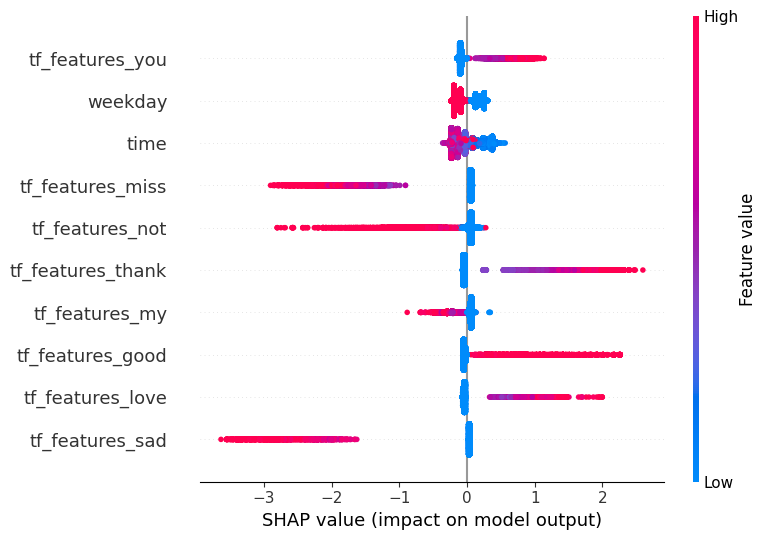

In [15]:
#Initializing shap explainer
explainer=shap.TreeExplainer(xgb)

#Calculating shap values
shap_values=explainer.shap_values(X_test)

#Visualizing shap
shap.summary_plot(shap_values, X_test, max_display=10)

The SHAP visualization explains the impact of different features on the model’s prediction for each sample. A positive SHAP value, such as +3, means that the corresponding feature increased the model's prediction for that particular sample by 3 units. Conversely, a negative SHAP value, for example -2, indicates that the feature decreased the model's prediction for that sample by 2 units. If the SHAP value is 0, it means that the feature had no effect on the model’s prediction for that specific instance.
In thsi way the shap values quantify how much each feature contributes (positively or negatively) to the prediction for each individual data point.

**Top 10 feature interpretation and its Business Meaning**

1. tf_features_you

- Low Value- It is indicated by blue color. It pushes the prediction down. 
- High Value- It is indicated by red color. It pushes the prediction up.
- Impact- The presence of "you" likely increases positive sentiment or engagement
- Business Meaning- Using "you" adds personal touch, indicating personalization matters.

2. weekday

- High Value- Mostly high value indicated by red color. 
- Impact- It pushes the prediction slightly up.
- Business Meaning- Certain weekdays might correlate with more engagement or different sentiment patterns.

3. time

- High Value- It is indicated by red colour. 
- Impact- High time value means late in the day. It may have slightly positive or neutral effect.
- Business Meaning- Posting time might slightly influence predictions. For e.g.- Late post could be more/less engaging.

4. tf_features_miss

- High Value- It is indicated by red colour. It pushes prediction left.
- Impact- It has neagtive effect.
- Business Meaning- Mentions of "miss" often indicate sadness or longing indicating negative sentiment.

5. tf_features_not

- High Value- It is indicated by red colour. It pushes prediction left.
- Impact- It also has negative effect.
- Business Meaning- "Not" is commonly associated with negation or criticism ---> decreases sentiment score.

6. tf_features_thank

- High Value- It is indicated by red colour. It pushes prediction right.
- Impact- It has positive effect.
- Business Meaning- Gratitude is positive. It increases predicted score of the sentiment.

7. tf_features_my

- Impact- Its effect is mixed but stable.
- Business Meaning- It might indicate personalization but doesn't have strong predictive power.

8. tf_features_good 

- High Value- It is indicated by red color. It pushes prediction right.
- Impact- It has positive effect.
- Business Meaning- Positive language like "good" leads to higher sentiment prediction.

9. tf_features_love

- High Value- It is indicated by red colour. It pushes prediction right.
- Impact- It has strong positive effect.
- Business Meaning- Strong positive sentiment --->Likely a major positive indicator in model prediction.

10. tf_features_sad

- High Value- It is indicated by red colour. It pushes prediction left.
- Impact- It has a negative effect.
- Business Meaning- Expressing sadness clearly correlates with lower sentiment predictions.

In [24]:
#Saving model
joblib.dump(xgb, 'xg_boost_model.pkl')

['xg_boost_model.pkl']

                                                              Comparison Table
                                                      
                                    Model                  |       Accuracy      |      F1 Score     |
                                                           |                     |                   |
                           1. Random Forest Classifier     |        72.1%        |       72.2%       | 
                           2. Logistic Regression          |        59.2%        |       60.2%       |
                           3. XGBoost Model                |        72.1%        |       73.1%       |
                                                           |                     |                   |

The comparison table shows that both the Random Forest classifier and the XGBoost model achieve the highest accuracy of 72.1%, indicating 
similar overall predictive performance. However, when considering the F1 score, which balances precision and recall, XGBoost slightly 
outperforms Random Forest with a score of 73.1% compared to 72.2%. This suggests that XGBoost provides a better balance between correctly 
identifying positive cases and avoiding false positives. Logistic Regression performs noticeably worse, with an accuracy of 59.2% and an 
F1 score of 60.2%, indicating that the linear model may not be capturing the underlying patterns as effectively as the tree-based models. 
Overall, XGBoost emerges as the preferred model given its slightly better F1 score while maintaining high accuracy.

**<font size="6">Thank You</font>**